In [49]:
import cv2
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
import os
import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset,DataLoader,dataset,ConcatDataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.ops.boxes import nms
from torchvision import transforms



In [50]:
alphabet = '-0123456789abcdefghijklmnopqrstuvwxyz'

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
import torch
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2)) # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2)) # 128x8x32
        convRelu(2, True)
        cnn.add_module('pooling{0}'.format(2), nn.MaxPool2d((2, 2), (2, 1), (0, 1))) # 256x4x16
        convRelu(3)
        cnn.add_module('pooling{0}'.format(3), nn.MaxPool2d((2, 2), (2, 1), (0, 1))) # 512x2x16
        convRelu(4, True)
        cnn.add_module('pooling{0}'.format(4), nn.MaxPool2d((2, 2), (2, 1), (0, 0))) # 512x1x16

        cnn.add_module('dropout{0}'.format(0), nn.Dropout(p=0.5))

        self.cnn = cnn
        self.rnn = nn.Sequential(
            nn.LSTM(512, nh, n_rnn, batch_first=True, bidirectional=True)
        )
        self.classifier = nn.Sequential(
            nn.Linear(nh * 2, nclass)
        )

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1) # [w, b, c]
        #print("conv",conv.shape)
        # rnn features
        recurrent, _ = self.rnn(conv)

        # classifier to yield output of the desired class
        output = self.classifier(recurrent)
        output = output.permute((1,0,2))
        #print("out",output.shape)
        return output


In [53]:
def get_value(name):
    return "".join([i for i in name if i.isdigit()])

In [54]:
dir_path = r"C:\Users\32233\PycharmProjects\temp\boxes_with_fixed_labels\train"

In [55]:
import time
features = []
for  i in os.listdir(dir_path):
    img = cv2.imread(os.path.join(dir_path,i))
    img = np.array(img)
    if img.shape[0]<img.shape[1]:
        img=img.transpose((2,0,1))
    else:
        img=img.transpose((2,1,0))
    img = Image.fromarray(img.transpose(1,2,0))
    
    img = img.resize((255,32))
    # display(img)
    # display(img.size)
    #plt.imshow(Image.fromarray(img[0]))
    #display(np_image.shape)
    features.append(torch.Tensor(np.array(img).transpose(2,0,1)).to(device))
    # print(os.path.join(dir_path,i))
    # img = Image.open(os.path.join(dir_path,i))
    # print(np.array(img).shape)
    # ts_img = torchvision.transforms.ToTensor(img)
    # display(ts_img)
    # features.append([])
features=torch.stack(features)
display(features.shape)


torch.Size([215, 3, 32, 255])

In [56]:
alphabet = '0123456789abcdefghijklmnopqrstuvwxyz-'

In [57]:
targets = []
for  i in os.listdir(dir_path):
    value = get_value(i.split('_')[0])
    y=torch.zeros(64,37)
    k=0
    j=0
    for k in value:
        y[j][alphabet.index(k)]=1
        j+=1
    #display(torch.Tensor(y))
    targets.append(y)
targets = torch.stack(targets)
targets = torch.tensor(targets)
display(targets.shape)

C:\Users\32233\AppData\Local\Temp\ipykernel_27376\2838561410.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets)


torch.Size([215, 64, 37])

In [58]:
display(features.shape)
display(targets.shape)

torch.Size([215, 3, 32, 255])

torch.Size([215, 64, 37])

In [59]:
train_data = torch.utils.data.TensorDataset(features,targets)
display(len(train_data)  )
data_loader = DataLoader(train_data, batch_size = 32, shuffle=True)

215

In [60]:
num_classes = 37
num_epochs = 5

In [61]:
def train(model, opt, loss_fn, epochs, train_data):

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for  X, Y in train_data:
            X= X.to(device)# data to device
            Y = Y.to(device)
            #display(X.shape,Y.shape)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X)
            plt.imshow(Y_pred[0].to('cpu').detach().numpy())
            #print(X.shape,"X",Y.shape,"Y",Y_pred.shape,"ypred")
            loss = loss_fn(Y,Y_pred) # forward-pass
            loss.backward()# backward-pass
            opt.step()# update weights
            # calculate loss to show the user
            avg_loss += loss / len(train_data)
    print(avg_loss)

In [62]:
model = CRNN(32,3,37,256).to(device)

* Epoch 1/100
* Epoch 2/100
* Epoch 3/100
* Epoch 4/100
* Epoch 5/100
* Epoch 6/100
* Epoch 7/100
* Epoch 8/100
* Epoch 9/100
* Epoch 10/100
* Epoch 11/100
* Epoch 12/100
* Epoch 13/100
* Epoch 14/100
* Epoch 15/100
* Epoch 16/100
* Epoch 17/100
* Epoch 18/100
* Epoch 19/100
* Epoch 20/100
* Epoch 21/100
* Epoch 22/100
* Epoch 23/100
* Epoch 24/100
* Epoch 25/100
* Epoch 26/100
* Epoch 27/100
* Epoch 28/100
* Epoch 29/100
* Epoch 30/100
* Epoch 31/100
* Epoch 32/100
* Epoch 33/100
* Epoch 34/100
* Epoch 35/100
* Epoch 36/100
* Epoch 37/100
* Epoch 38/100
* Epoch 39/100
* Epoch 40/100
* Epoch 41/100
* Epoch 42/100
* Epoch 43/100
* Epoch 44/100
* Epoch 45/100
* Epoch 46/100
* Epoch 47/100
* Epoch 48/100
* Epoch 49/100
* Epoch 50/100
* Epoch 51/100
* Epoch 52/100
* Epoch 53/100
* Epoch 54/100
* Epoch 55/100
* Epoch 56/100
* Epoch 57/100
* Epoch 58/100
* Epoch 59/100
* Epoch 60/100
* Epoch 61/100
* Epoch 62/100
* Epoch 63/100
* Epoch 64/100
* Epoch 65/100
* Epoch 66/100
* Epoch 67/100
* Ep

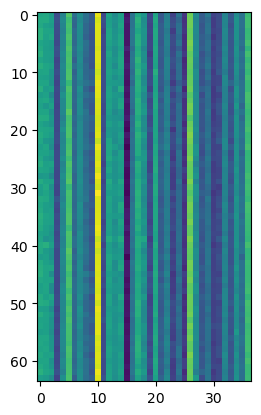

In [63]:
max_epochs = 100
optim = torch.optim.Adam(model.parameters())
train(model, optim, nn.functional.l1_loss, max_epochs, data_loader)

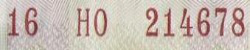

torch.Size([1, 3, 50, 250])

torch.Size([1, 63, 37])

a q q q q l q a c q 4 q a h h q a a a - a a l c a a q a a q - l h q c o q q l o q h q q l h l q a a c c l a l l q q a q q q q 

In [64]:
file = Image.open(r"C:\\Users\\32233\\PycharmProjects\\temp\\boxes_with_fixed_labels\\train\\16HO214678.jpg")
display(file)
ts = torch.tensor(np.array(file))/255
ts = ts.permute((2,0,1))
ts = ts[None,:,:,:]
display(ts.shape)
res = model(ts.to(device))
display(res.shape)
for j in range(len(res[0])):
    print(alphabet[res[0][j].argmax()],end= " ")

In [65]:
import torch.optim as optim

# Assuming you have your dataset loaded and split into train_loader and val_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(imgH=32, nc=1, nclass=num_classes, nh=256).to(device)
criterion = nn.CTCLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels, lengths, lengths)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')


RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[32, 3, 32, 255] to have 1 channels, but got 3 channels instead

In [ ]:
from torchsummary import summary
summary(model,input_size=(255,32))

In [ ]:
train_data = torch.utils.data.TensorDataset(features,targets)
display(len(train_data)  )
data_loader = DataLoader(train_data, batch_size = 32, shuffle=True)

822